In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm as tqdm
import sys

sys.path.append('..')
import interpolator
import pyvo

import pyphot

#sys.path.append('../..')
#import wdtools_nicole as wdtools

import sys, os
wdmodels_dir = os.environ['WDMODELS_DIR']
sys.path.append(wdmodels_dir)
import WD_models

plt.style.use('stefan.mplstyle')

In [2]:
"""compute the radial velocity from radius and effective temperature
"""
mass_sun, radius_sun, newton_G, speed_light = 1.9884e30, 6.957e8, 6.674e-11, 299792458
font_model = WD_models.load_model('f', 'f', 'f', 'H')
g_acc = (10**font_model['logg'])/100
rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_function = WD_models.interp_xy_z_func(x = 10**font_model['logteff'], y = font_model['logg'],\
                                            z = rsun, interp_type = 'linear')

In [3]:
"""build the model SED using default filters
"""
defaults = interpolator.atmos.sed.get_default_filters({'zerofile' : 'alpha_lyr_stis_011'})
SED = interpolator.atmos.WarwickPhotometry('1d_da_nlte', [defaults['Gaia_G'], defaults['Gaia_BP'], defaults['Gaia_RP']], units = 'flam')
SED.zeropoints

array([21.50298444, 20.97310752, 22.2411774 ])

In [4]:
interp, (T, L, A, grid_sansav, grid) = SED.make_cache(nAV=40)
T[0], L[0], A[0], grid[0,0], interp(T[0], L[0])

(np.float64(1500.0000000000005),
 np.float64(6.49996186559619),
 np.float64(0.0001),
 array([[3698.45485409, 5756.8332602 , 2035.58281343],
        [3660.73169012, 5693.66554961, 2018.86508826],
        [3623.40550163, 5631.20149917, 2002.28928854],
        [3586.47199288, 5569.43313883, 1985.8541785 ],
        [3549.92691586, 5508.35259044, 1969.55853337],
        [3513.7660697 , 5447.95206672, 1953.40113921],
        [3477.98530019, 5388.22387016, 1937.38079288],
        [3442.5804992 , 5329.16039197, 1921.49630188],
        [3407.5476042 , 5270.75411106, 1905.74648431],
        [3372.88259772, 5212.99759298, 1890.13016875],
        [3338.5815068 , 5155.88348891, 1874.64619415],
        [3304.64040257, 5099.40453466, 1859.29340977],
        [3271.05539966, 5043.55354967, 1844.07067507],
        [3237.82265576, 4988.32343604, 1828.9768596 ],
        [3204.93837113, 4933.70717755, 1814.01084295],
        [3172.39878808, 4879.69783871, 1799.17151463],
        [3140.20019052, 4826.288563

In [5]:
theta = [10000, 8.001777261158344, 100, 0]
interpolator.fit.get_model_flux(theta, interp, logg_function=logg_function), 

(array([3.42911355e-16, 5.34228965e-16, 1.91405711e-16]),)

In [6]:
theta = [10000, 0.01281575, 100, 0, 0.6]
interpolator.fit.get_model_flux(theta, interp, logg_function=None), 

(array([3.42920934e-16, 5.34246308e-16, 1.91407879e-16]),)

In [7]:
logg= np.log10(100*(newton_G * mass_sun * 0.6) / (0.0128 * radius_sun)**2)
rad2 = logg_function(10000, logg)
rad2

array(0.01281575)

In [8]:
# array([21.50762303, 20.97943774, 22.24345324])

In [9]:
def mag_to_flux(mag : np.array, e_mag : np.array):
    """convert vega magnitudes to fluxes in flam units
    """
    flux = np.power(10, -0.4*(mag - np.array([-21.48503, -20.96683, -22.22089])))  
    e_flux = 1.09 * flux * e_mag
    return flux, e_flux

def loss(params, fl, e_fl, plx, av):
    pc_to_m, radius_sun = 3.08568e16, 6.957e8
    teff, logg = params.valuesdict().values()
    theta = np.array([teff, logg, 1000 / plx, 0])
    flux_model = interpolator.fit.get_model_flux(theta, interp, logg_function=logg_function)
    return (fl - flux_model) / e_fl

In [10]:
tap_service = pyvo.dal.TAPService("http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap/")
QUERY = f"""select top 1000 *
        from \"J/MNRAS/508/3877/maincat\"
        where TeffH is not NULL and MassH is not NULL and meanAV is not NULL and RPlx > 3"""
ngfdata = tap_service.search(QUERY).to_table().to_pandas()

In [11]:
import lmfit

values = np.zeros((len(ngfdata), 4))
for i, row in tqdm.tqdm(ngfdata.iterrows(), total=len(ngfdata)):
    extinction = np.array([0.835*row.meanAV, 1.139*row.meanAV, 0.650*row.meanAV])
    mags = row[['GmagCorr', 'BPmag', 'RPmag']].values - extinction# + 5*(np.log10((row.Plx - row.ZPcor)*1e-3) + 1)
    e_mags = row[['e_GmagCorr', 'e_BPmag', 'e_RPmag']].values
    fluxes, e_fluxes = SED.mag_to_flux(mags, e_mags)

    params = lmfit.Parameters()
    params.add('teff', value=10000, min=2000, max=50000, vary=True)
    params.add('logg', value=8, min=7.15, max=9, vary=True)

    res = lmfit.minimize(loss, params, args = (fluxes, e_fluxes, row.Plx - row.ZPcor, 0))
    teff, logg = res.params['teff'].value, res.params['logg'].value
    values[i,0] = row.GaiaEDR3
    values[i,1] = teff
    values[i,2] = logg
    values[i,3] = res.redchi
leastsq = pd.DataFrame(values, columns=['GaiaEDR3', 'teff', 'logg', 'redchi'])

100%|██████████| 1000/1000 [00:07<00:00, 131.12it/s]


In [12]:
def interpolate_massteff(massarray : np.array, teffarray : np.array, Hlayer : str = 'thick') -> np.array:
    """compute the radial velocity from mass and effective temperature
    """
    assert Hlayer in ['thick', 'thin'], 'Hlayer must be either "thick" or "thin"'
    mass_sun, radius_sun, newton_G, speed_light = 1.9884e30, 6.957e8, 6.674e-11, 299792458
    font_model = WD_models.load_model('f', 'f', 'f', 'H') if Hlayer == 'thick' else WD_models.load_model('f', 'ft', 'f', 'H')
    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    mass_teff_to_radius = WD_models.interp_xy_z_func(x = font_model['mass_array'], y = 10**font_model['logteff'],\
                                                z = rsun, interp_type = 'linear')
    radius = mass_teff_to_radius(massarray, teffarray)
    return radius

ngfdata['RadiusH'] = interpolate_massteff(ngfdata.MassH.values, ngfdata.TeffH.values, Hlayer = 'thick')
leastsq['radius'] = logg_function(leastsq.teff, leastsq.logg)
leastsq['mass'] = (1e-2*10**leastsq.logg * ((leastsq.radius*radius_sun)**2 / newton_G))/mass_sun
leastsq = leastsq.query("mass > 0.46")

In [13]:
comparison = pd.merge(leastsq, ngfdata, on='GaiaEDR3')
comparison['teff_pct_err'] = (comparison.teff - comparison.TeffH) / comparison.teff * 100
comparison['logg_pct_err'] = (comparison.logg - comparison.loggH) / comparison.logg * 100
comparison['ngf_dist'] = 1000 / (comparison.Plx + comparison.ZPcor)

(-10.0, 10.0)

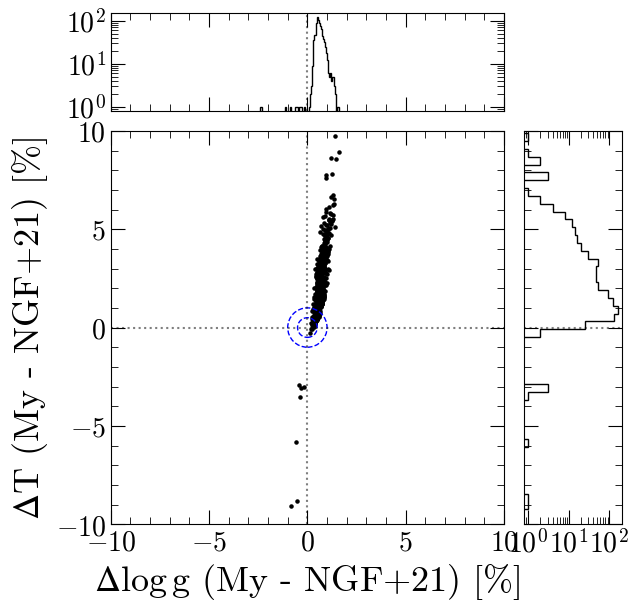

In [14]:
import matplotlib.patches as patches

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # the scatter plot:
    scatter = ax.scatter(x, y, c='k', s = 5)
    ax.axhline(y = 0, ls = ':', alpha = 0.5, c = 'k')
    ax.axvline(x = 0, ls = ':', alpha = 0.5, c = 'k')
    # now determine nice limits by hand:
    binwidth = 0.5
    ax_histx.hist(x, color = 'k', histtype = 'step')
    ax_histx.axvline(x = 0, ls = ':', alpha = 0.5, c = 'k')
    ax_histy.hist(y, orientation='horizontal', color = 'k', histtype = 'step')
    ax_histy.axhline(y = 0, ls = ':', alpha = 0.5, c = 'k')
    ax_histx.set_yscale('log')
    ax_histy.set_xscale('log')
    return scatter

fig = plt.figure(layout='constrained', figsize=(8,6))
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax.set(aspect=1)

ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)

temp_compare = comparison.copy()
scatter_mass = scatter_hist(temp_compare.logg_pct_err, temp_compare.teff_pct_err, ax = ax, 
                            ax_histx = ax_histx, ax_histy = ax_histy)
confidence_ellipses = [0.5, 1]
for val in confidence_ellipses:
    circle = patches.Circle((0, 0), val, edgecolor='blue', facecolor='none', ls = '--', linewidth=1, label='')
    ax.add_patch(circle)
ax.set_xlabel(r'$\Delta \log g$ (My - NGF+21) [%]')
ax.set_ylabel(r'$\Delta T$ (My - NGF+21) [%]')
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)

In [15]:
10**(-0.4*SED.zeropoints)

array([2.50499132e-09, 4.08090977e-09, 1.26919700e-09])

In [16]:
-2.5*np.log10([2.49e-9, 4.04e-9, 1.28e-9])

array([21.50950163, 20.98404659, 22.23197508])